In [18]:
import matplotlib.pyplot as plt
from Objects.Simulation import Simulation
import numpy as np
import pandas as pd
from copy import deepcopy
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [19]:
from matplotlib import lines, markers
from cycler import cycler

# Create cycler object. Use any styling from above you please
monochromeWithMarker = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '-.']) * cycler('marker', [ '.' ,'^']))
monochromeNoMarker = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '-.']) * cycler('marker', [',']))
monochrome = monochromeNoMarker.concat(monochromeWithMarker)

plt.set_cmap('gray')
# Overriding styles for current script
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['figure.figsize'] = (12,5)
mpl.rcParams['figure.dpi']= 300
plt.rcParams['axes.prop_cycle'] = monochrome

<Figure size 432x288 with 0 Axes>

In [20]:
def cal_one_p(p):
    return np.mean(p.delays), np.max(p.delays)

def cal_vdr(ps, tg):
    if type(ps) is not list:
        ps = [ps]
    total_vehPass = 0
    total_tg = 0
    for p in ps:
        total_vehPass += p.vehPass
        total_tg += tg
    return total_vehPass / total_tg * 3600

def get_data_array(p,tg):
    delaymean, delaymax = cal_one_p(p)
    return [delaymean, delaymax, cal_vdr(p, tg)]

In [21]:
simulation_time = 60 # seconds
n = 100 # number of vehicles
intended_speed = 80 * 1000/3600 # intended speed / speed limit of the road
sim = Simulation(time = simulation_time, avStep = 100)


LRT = [1.4, -1.4]
HSR = [0.5, -0.5]

human_profile = [1.7, -2.0]
av_profile = HSR

paras={
    'v_intend': intended_speed,
    'human_max_acc': human_profile[0],
    'human_max_dec': human_profile[1],
    'max_acc': av_profile[0],
    'max_dec': av_profile[1],
    'tsys': 1.0,
    'human_T': 1.8,
    'AV_T': 1.6
}

human = sim.run_human_simulation(n, paras)
human = get_data_array(human, simulation_time)

av = sim.run_av_simulation(n,paras)
av = get_data_array(av, simulation_time)

cav = sim.run_cav_simulation(n,paras)
cav = get_data_array(cav, simulation_time)

In [22]:
human

[21.045918298965475, 39.95519946607026, 1800.0]

In [23]:
nth_av_lrt_result = []
nth_av_hsr_result = []
av_profile = HSR
paras={
    'v_intend': intended_speed,
    'human_max_acc': human_profile[0],
    'human_max_dec': human_profile[1],
    'max_acc': av_profile[0],
    'max_dec': av_profile[1],
    'tsys': 1.0,
    'human_T': 1.8,
    'AV_T': 1.6
}

for i in range(20):
    av_profile = LRT
    paras={
        'v_intend': intended_speed,
        'human_max_acc': human_profile[0],
        'human_max_dec': human_profile[1],
        'max_acc': av_profile[0],
        'max_dec': av_profile[1],
        'tsys': 1.0,
        'human_T': 1.8,
        'AV_T': 1.6
    }
    av_nth = sim.run_nth_vehicle_simulation(n,paras, vehtype=1, nth = i)
    av_lrt = get_data_array(av_nth, simulation_time)
    nth_av_lrt_result.append(av_lrt)
    av_profile = HSR
    paras={
        'v_intend': intended_speed,
        'human_max_acc': human_profile[0],
        'human_max_dec': human_profile[1],
        'max_acc': av_profile[0],
        'max_dec': av_profile[1],
        'tsys': 1.0,
        'human_T': 1.8,
        'AV_T': 1.6
    }
    av_nth = sim.run_nth_vehicle_simulation(n,paras, vehtype=1, nth = i)
    av_hsr = get_data_array(av_nth, simulation_time)
    nth_av_hsr_result.append(av_hsr)

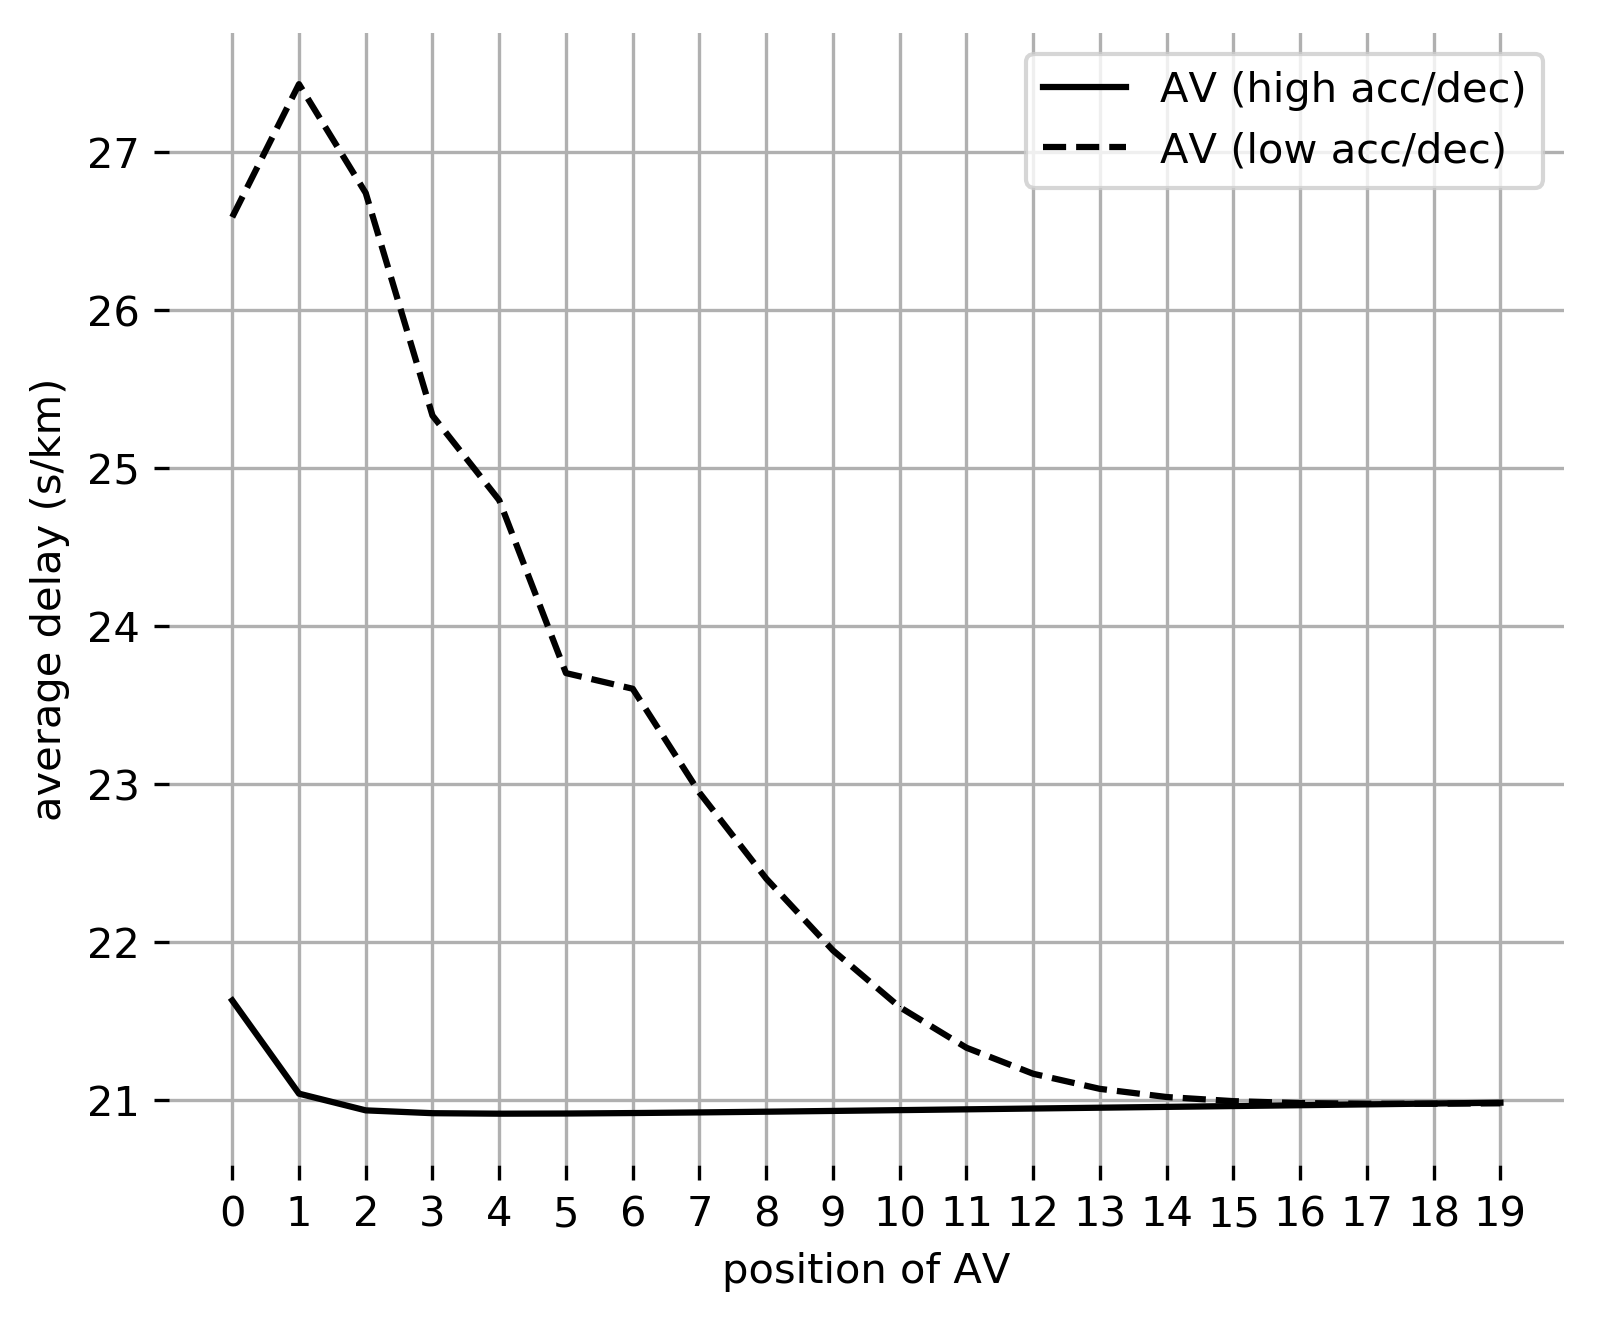

In [47]:
def map_to_dim(array, dim):
    array = [x[dim] for x in array]
    return array[0:20]

x = range(20)
plt.figure(figsize=(6,5))
plt.xlabel("position of AV")
plt.ylabel("average delay (s/km)")
plt.xticks(x)
dim = 0
plt.plot(x, map_to_dim(nth_av_lrt_result,dim), label = "AV (high acc/dec)")
plt.plot(x, map_to_dim(nth_av_hsr_result,dim), label = "AV (low acc/dec)")
plt.legend(title='')

Text(0,0.5,'VDR (veh/h)')

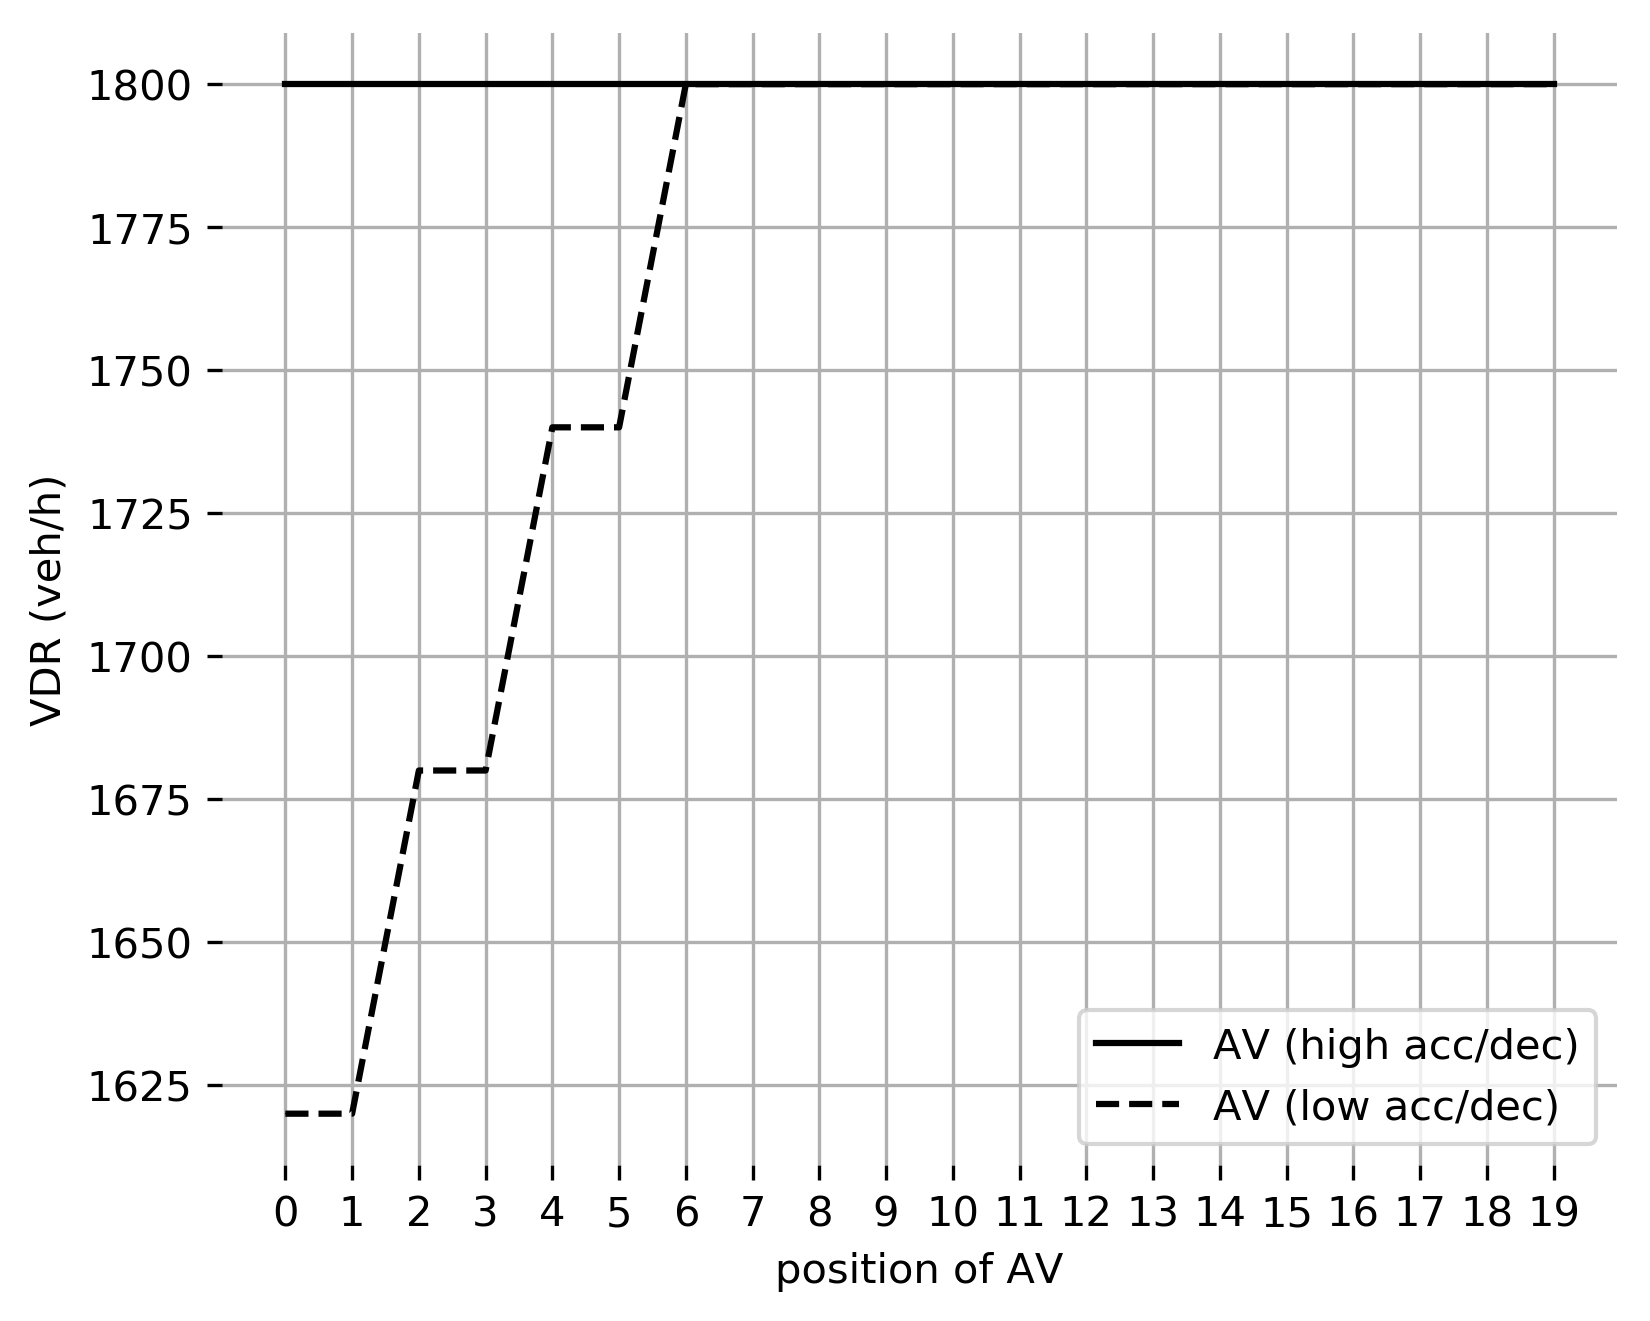

In [25]:
dim =2
plt.figure(figsize=(6,5))
plt.plot(x, map_to_dim(nth_av_lrt_result,dim), label = "AV (high acc/dec)")
plt.plot(x, map_to_dim(nth_av_hsr_result,dim), label = "AV (low acc/dec)")
plt.legend(title='')
plt.xticks(x)
plt.xlabel("position of AV")
plt.ylabel("VDR (veh/h)")


In [26]:
# mix human with AV
av_profile = LRT

paras={
    'v_intend': intended_speed,
    'human_max_acc': human_profile[0],
    'human_max_dec': human_profile[1],
    'max_acc': av_profile[0],
    'max_dec': av_profile[1],
    'tsys': 1.0,
    'human_T': 1.8,
    'AV_T': 1.6
}
human_av_lrt = {}
human_cav_lrt = {}
for i in range(6):
    av_ratio = i * 0.2
    human_ratio = 1-av_ratio
    human_av_lrt[i] = []
    human_cav_lrt[i] = []
    print(human_ratio)
    for j in range(20):
        mixed = sim.run_mixed_simulation(n,paras,[human_ratio,av_ratio])
        result=deepcopy(get_data_array(mixed, simulation_time))
        human_av_lrt[i].append(result)
    for j in range(20):
        mixed = sim.run_mixed_simulation(n,paras,[human_ratio,0])
        result=deepcopy(get_data_array(mixed, simulation_time))
        human_cav_lrt[i].append(result)

1.0
0.8
0.6
0.3999999999999999
0.19999999999999996
0.0


In [27]:
# mix human with AV
av_profile = HSR

paras={
    'v_intend': intended_speed,
    'human_max_acc': human_profile[0],
    'human_max_dec': human_profile[1],
    'max_acc': av_profile[0],
    'max_dec': av_profile[1],
    'tsys': 1.0,
    'human_T': 1.8,
    'AV_T': 1.6
}
human_av_hsr = {}
human_cav_hsr = {}
for i in range(6):
    av_ratio = i * 0.2
    human_ratio = 1-av_ratio
    human_av_hsr[i] = []
    human_cav_hsr[i] = []
    print(human_ratio)
    for j in range(20):
        mixed = sim.run_mixed_simulation(n,paras,[human_ratio,av_ratio])
        result=get_data_array(mixed, simulation_time).copy()
        human_av_hsr[i].append(result)
    for j in range(20):
        mixed = sim.run_mixed_simulation(n,paras,[human_ratio,0])
        result=get_data_array(mixed, simulation_time).copy()
        human_cav_hsr[i].append(result)

1.0
0.8
Vehicle 98 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 37 h

Vehicle 18 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 18 hit the leader ve

Vehicle 24 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 41 hit the l

Vehicle 60 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 44 hit the l

Vehicle 51 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 51 hit the l

Vehicle 9 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 12 hit the leader 

Vehicle 64 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 43 hit the l

Vehicle 19 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 47 hit the l

Vehicle 21 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 61 hit the l

Vehicle 8 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 36 hit the lead

Vehicle 7 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 32 hit the leader

Vehicle 11 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 34 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 34 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 34 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 83 hit the l

Vehicle 11 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 69 hit the l

Vehicle 3 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 3 hit the leader veh

Vehicle 18 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 56 hit the l

Vehicle 6 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 51 hit the lead

Vehicle 13 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 17 hit the lead

Vehicle 20 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 55 hit the l

Vehicle 26 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the l

Vehicle 16 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 59 hit the lead

0.3999999999999999
Vehicle 8 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 87 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 87 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehi

Vehicle 9 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 98 hit the lead

Vehicle 9 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 79 hit the lead

Vehicle 5 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 27 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 27 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 5 hit the leader

Vehicle 6 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 87 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 82 hit the leade

Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 33 hit the l

Vehicle 3 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 3 hit the lead

Vehicle 5 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 74 hit the lea

Vehicle 4 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 67 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 67 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 38 hit the leader 

Vehicle 4 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 34 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 34 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 74 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 4 hit the leader

Vehicle 3 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 94 hit the lea

Vehicle 5 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 82 hit the leader

Vehicle 12 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 12 hit the lea

Vehicle 5 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 89 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 5 hit the leader

Vehicle 8 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 34 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 91 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 34 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 81 hit the lea

Vehicle 5 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 87 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 87 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 15 hit the lead

Vehicle 7 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 17 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 17 hit the lead

Vehicle 6 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 48 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 11 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 32 hit the lead

Vehicle 4 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader 

Vehicle 5 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 91 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 40 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 70 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 88 hit the lea

0.19999999999999996
Vehicle 6 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicl

Vehicle 3 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 95 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 18 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 90 hit the leade

Vehicle 4 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 98 hit the leader vehicle!
Vehicle 4 hit the lead

Vehicle 8 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 20 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 78 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 20 hit the lead

Vehicle 4 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 27 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 87 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 15 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 27 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 37 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 65 hit the leader vehicle!
Vehicle 68 hit the lea

Vehicle 5 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 22 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 57 hit the leader vehicle!
Vehicle 62 hit the leader 

Vehicle 9 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 67 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 47 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 67 hit the leader vehicle!
Vehicle 76 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 32 hit the lead

Vehicle 6 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 30 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 12 hit the leader vehicle!
Vehicle 19 hit the leader

Vehicle 3 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 91 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 84 hit the leader vehicle!
Vehicle 91 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 8 hit the leader vehicle!
Vehicle 13 hit the leader 

Vehicle 6 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 24 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 80 hit the leader vehicle!
Vehicle 92 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 10 hit the leade

Vehicle 19 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 56 hit the leader vehicle!
Vehicle 62 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 33 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 56 hit the lea

Vehicle 7 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 71 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 2 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 36 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 58 hit the leader

Vehicle 5 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 54 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 66 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 93 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 9 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 39 hit the leader vehicle!
Vehicle 43 hit the leader vehicle!
Vehicle 50 hit the leader vehicle!
Vehicle 54 hit the leader 

Vehicle 3 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 31 hit the leader vehicle!
Vehicle 45 hit the leader vehicle!
Vehicle 59 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 69 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 23 hit the leader 

Vehicle 3 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 87 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 26 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 73 hit the leader vehicle!
Vehicle 79 hit the leader vehicle!
Vehicle 87 hit the leader vehicle!
Vehicle 90 hit the leader vehicle!
Vehicle 96 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 3 hit the leader vehicle!
Vehicle 16 hit the leader vehicle!
Vehicle 26 hit the lead

Vehicle 6 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 83 hit the leader vehicle!
Vehicle 6 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 21 hit the leader vehicle!
Vehicle 28 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 55 hit the leader vehicle!
Vehicle 61 hit the leader vehicle!
Vehicle 64 hit the leader vehicle!
Vehicle 68 hit the lead

Vehicle 7 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 72 hit the leader vehicle!
Vehicle 75 hit the leader vehicle!
Vehicle 85 hit the leader vehicle!
Vehicle 91 hit the leader vehicle!
Vehicle 7 hit the leader vehicle!
Vehicle 13 hit the leader vehicle!
Vehicle 25 hit the leader vehicle!
Vehicle 29 hit the leader vehicle!
Vehicle 35 hit the leader vehicle!
Vehicle 38 hit the leader vehicle!
Vehicle 41 hit the leader vehicle!
Vehicle 44 hit the leader vehicle!
Vehicle 49 hit the leader vehicle!
Vehicle 53 hit the leader vehicle!
Vehicle 60 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 72 hit the lea

Vehicle 4 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 91 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 42 hit the leader vehicle!
Vehicle 51 hit the leader vehicle!
Vehicle 82 hit the leader vehicle!
Vehicle 88 hit the leader vehicle!
Vehicle 91 hit the leader vehicle!
Vehicle 94 hit the leader vehicle!
Vehicle 99 hit the leader vehicle!
Vehicle 4 hit the leader vehicle!
Vehicle 10 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 19 hit the leader vehicle!
Vehicle 32 hit the lead

Vehicle 5 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 23 hit the leader vehicle!
Vehicle 32 hit the leader vehicle!
Vehicle 46 hit the leader vehicle!
Vehicle 52 hit the leader vehicle!
Vehicle 58 hit the leader vehicle!
Vehicle 63 hit the leader vehicle!
Vehicle 68 hit the leader vehicle!
Vehicle 77 hit the leader vehicle!
Vehicle 81 hit the leader vehicle!
Vehicle 86 hit the leader vehicle!
Vehicle 97 hit the leader vehicle!
Vehicle 5 hit the leader vehicle!
Vehicle 14 hit the leader vehicle!
Vehicle 23 hit the lead

0.0


In [28]:
human_cav_hsr == human_av_hsr

False

In [29]:
human_av_lrt[1], human_cav_lrt[1]

([[21.102868260906188, 40.26622684107648, 1860.0000000000002],
  [21.56402361009761, 40.83961312908126, 1860.0000000000002],
  [20.92374520426335, 39.623653254994615, 1800.0],
  [20.821711095287252, 39.98822173685191, 1860.0000000000002],
  [20.705956492221894, 39.415934720103195, 1800.0],
  [21.409595457311966, 40.44383986916866, 1860.0000000000002],
  [21.367674989345264, 40.13901144375411, 1800.0],
  [21.4272687534124, 40.882589405075066, 1860.0000000000002],
  [21.29487112828846, 40.448087292540265, 1860.0000000000002],
  [21.079453738035685, 40.30987638687332, 1860.0000000000002],
  [20.872118475924857, 39.42877667330036, 1800.0],
  [21.448419701614675, 40.444722818379965, 1860.0000000000002],
  [21.45137019376735, 40.251366668651954, 1860.0000000000002],
  [21.410295537064016, 40.699731565334545, 1860.0000000000002],
  [21.495574383251746, 40.64169473788374, 1860.0000000000002],
  [21.44860568930027, 40.409449598304406, 1860.0000000000002],
  [20.921437269674527, 39.5648263573994

In [30]:

def get_result(input_dict):
    result_array = {}
    for key,value in input_dict.items():
        result_array[key] = deepcopy([np.mean([x[0] for x in value]), np.mean([x[1] for x in value]), np.mean([x[2] for x in value])])
    return result_array


In [31]:

av_lrt = get_result(human_av_lrt)
av_hsr = get_result(human_av_hsr)
cav_lrt = get_result(human_cav_lrt)
cav_hsr = get_result(human_cav_hsr)

In [32]:
cav_hsr

{0: [21.04591829896548, 39.955199466070255, 1800.0],
 1: [34.564154504155596, 71.29684227630808, 1602.0],
 2: [38.62325739898829, 82.34566023364991, 1542.0],
 3: [39.0334185796383, 80.27643329762795, 1581.0],
 4: [30.960561775290017, 65.94638727640856, 1737.0],
 5: [13.090504520552889, 20.970700648831773, 2640.0]}

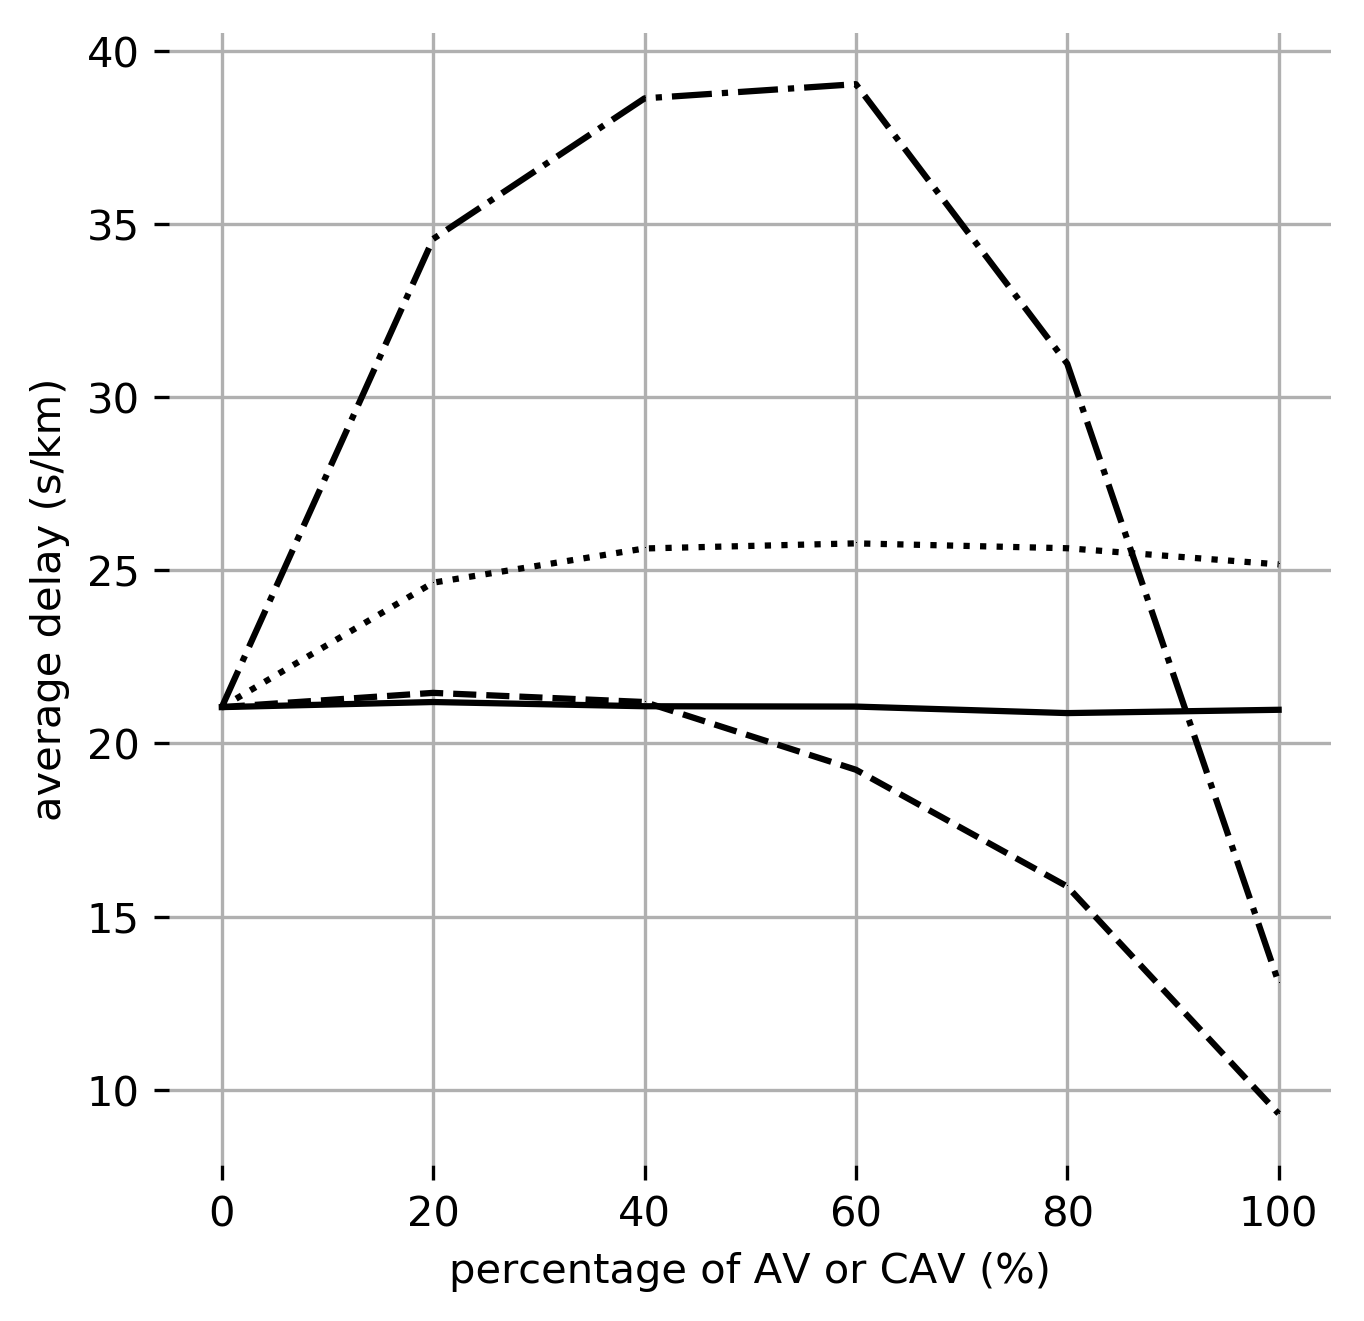

In [51]:
def map_to_dim(mydict, dim):
    res = np.array([mydict[x][dim] for x in sorted(mydict.keys())])
    return res

human_avg_delay, human_max_delay, human_vdr = human[0], human[1],human[2]

x = [x*20 for x in range(6)]
plt.figure(figsize=(5,5))
plt.xlabel("percentage of AV or CAV (%)")
plt.ylabel("average delay (s/km)")
dim = 0
plt.plot(x, map_to_dim(av_lrt,dim), label = "AV-LRT")
plt.plot(x, map_to_dim(cav_lrt,dim), label = "CAV-LRT")
plt.plot(x, map_to_dim(av_hsr,dim), label = "AV-HSR")
plt.plot(x, map_to_dim(cav_hsr,dim), label = "CAV-HSR")


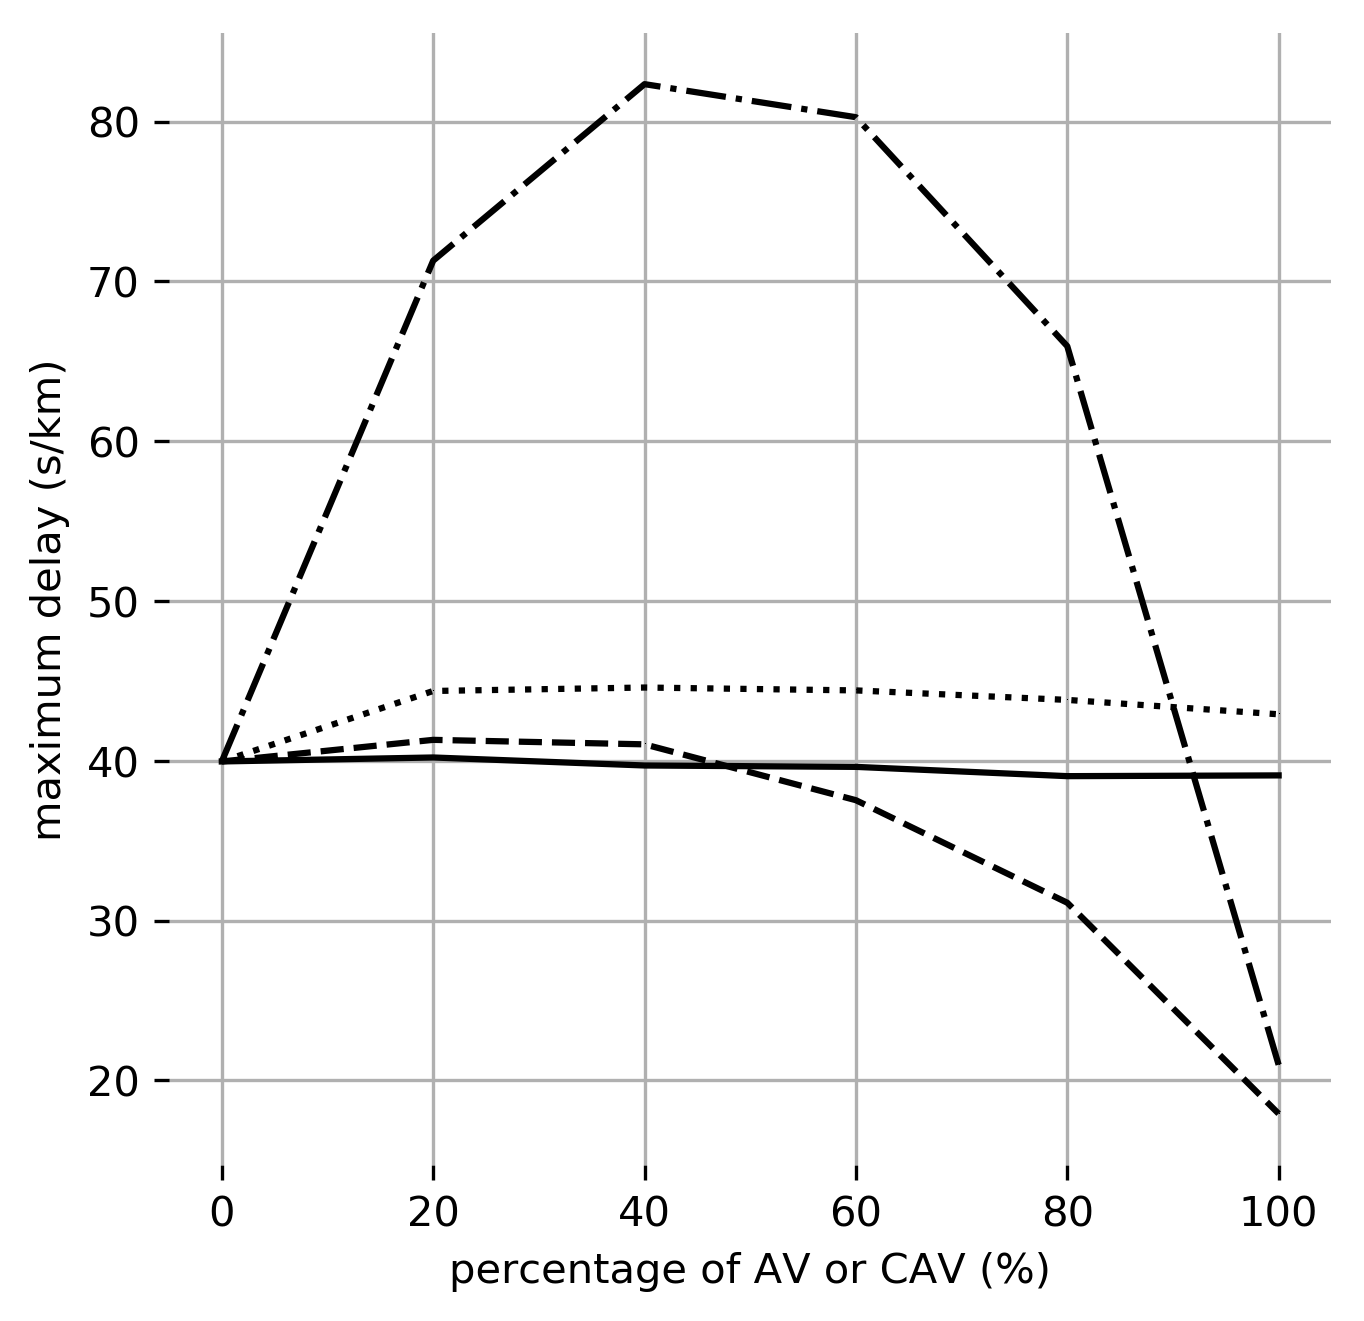

In [52]:
plt.figure(figsize=(5,5))
plt.xlabel("percentage of AV or CAV (%)")
plt.ylabel("maximum delay (s/km)")
dim =1
plt.plot(x, map_to_dim(av_lrt,dim), label = "AV-LRT")
plt.plot(x, map_to_dim(cav_lrt,dim), label = "CAV-LRT")
plt.plot(x, map_to_dim(av_hsr,dim), label = "AV-HSR")
plt.plot(x, map_to_dim(cav_hsr,dim), label = "CAV-HSR")


Text(0,0.5,'VDR (veh/h)')

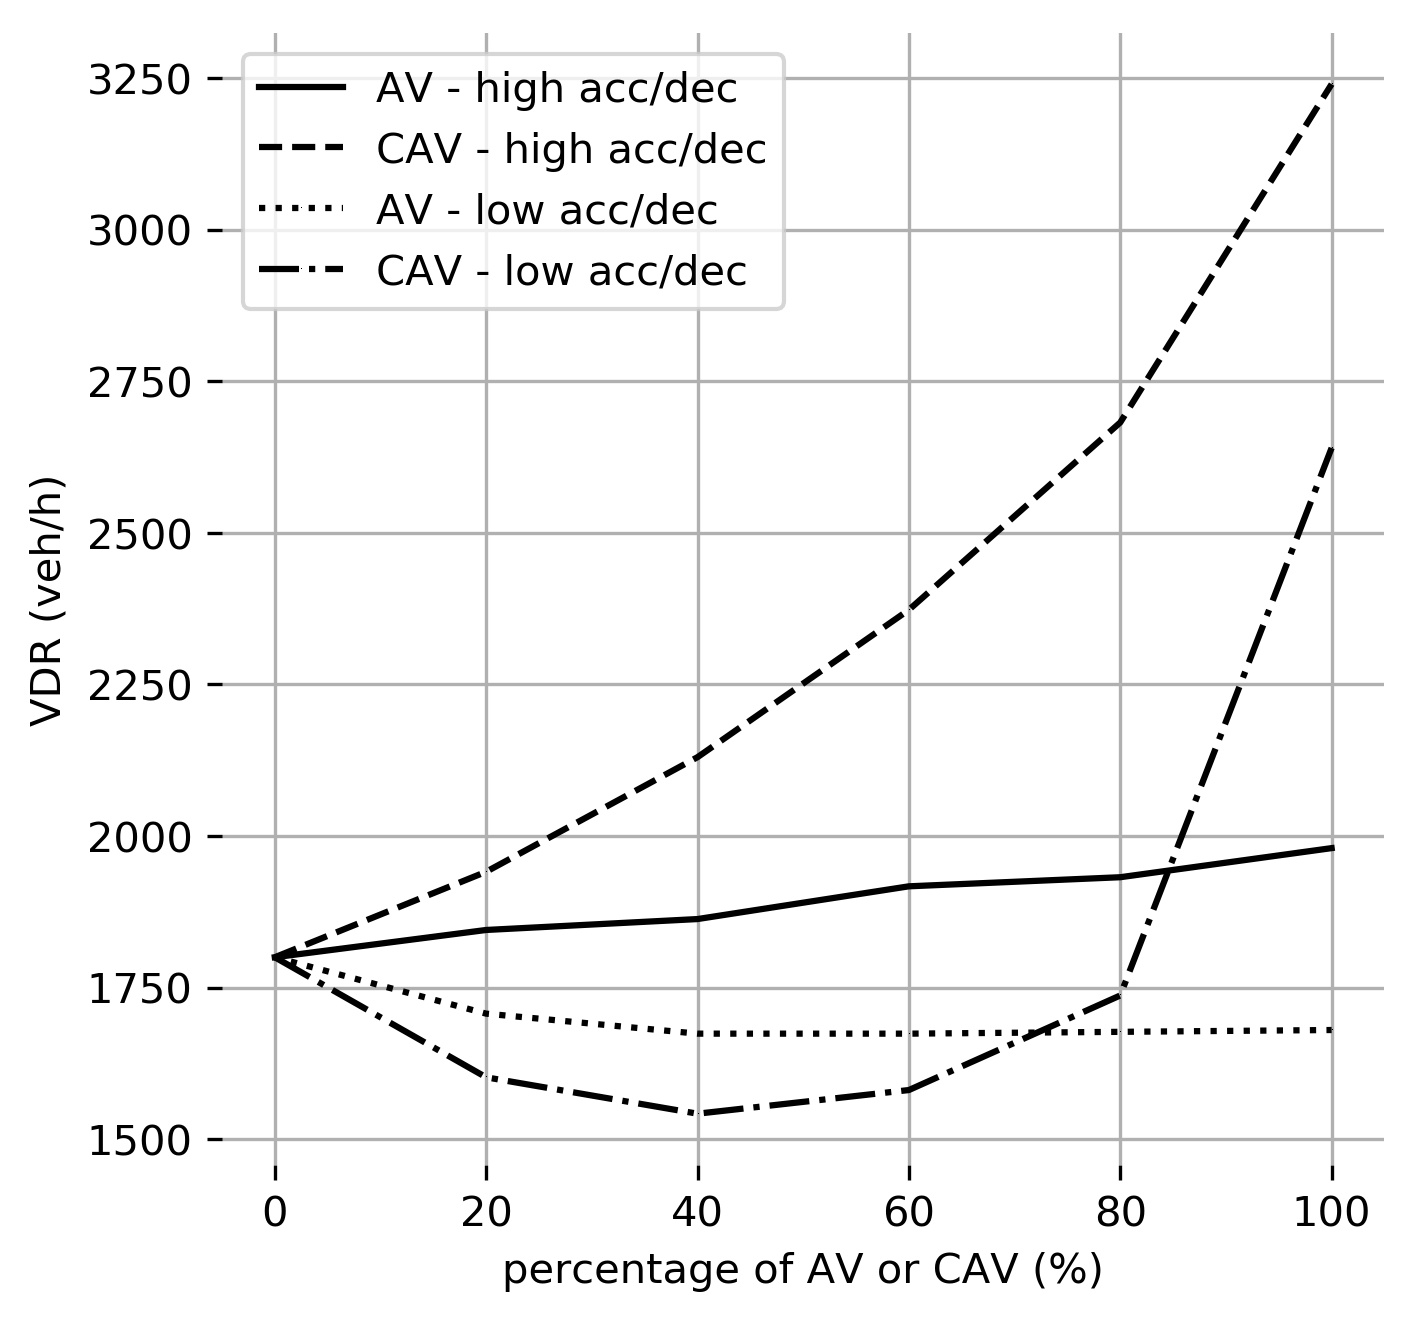

In [53]:
dim =2
plt.figure(figsize=(5,5))
plt.plot(x, map_to_dim(av_lrt,dim), label = "AV - high acc/dec")
plt.plot(x, map_to_dim(cav_lrt,dim), label = "CAV - high acc/dec")
plt.plot(x, map_to_dim(av_hsr,dim), label = "AV - low acc/dec")
plt.plot(x, map_to_dim(cav_hsr,dim), label = "CAV - low acc/dec")
plt.legend(title='')
plt.xlabel("percentage of AV or CAV (%)")
plt.ylabel("VDR (veh/h)")

Text(0,0.5,'VDR (veh/h)')

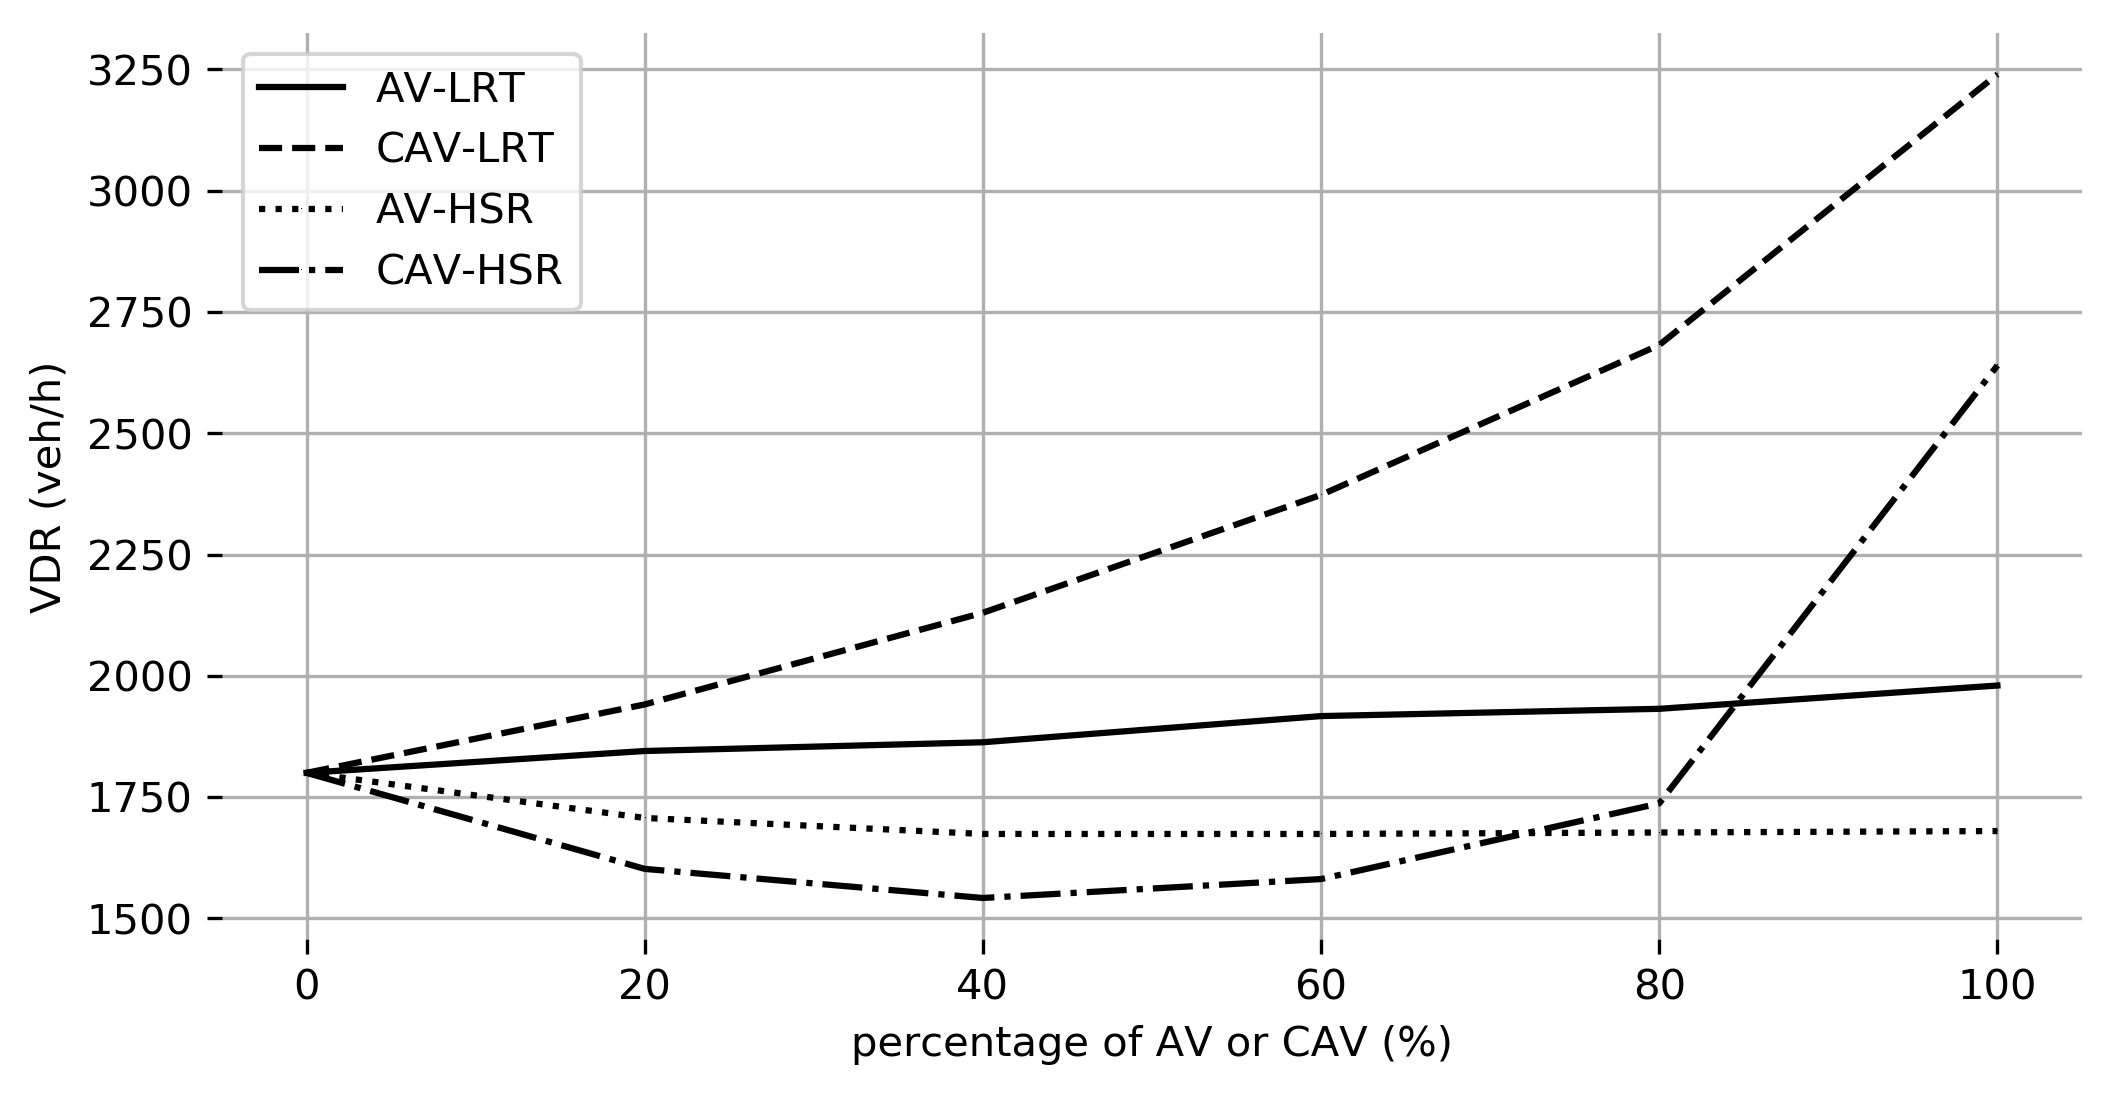

In [34]:
plt.figure(figsize=(8,4))
dim =2
plt.plot(x, map_to_dim(av_lrt,dim), label = "AV-LRT")
plt.plot(x, map_to_dim(cav_lrt,dim), label = "CAV-LRT")
plt.plot(x, map_to_dim(av_hsr,dim), label = "AV-HSR")
plt.plot(x, map_to_dim(cav_hsr,dim), label = "CAV-HSR")
plt.legend(title='')
plt.xlabel("percentage of AV or CAV (%)")
plt.ylabel("VDR (veh/h)")